In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import statistics
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import naive_bayes
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from graphviz import Source
from IPython.display import SVG
from IPython.display import display
from pydot import graph_from_dot_data
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
# Read in CSV file
data = pd.read_csv("data.csv").dropna()
data

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2,3,6,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,4860406,2011,10,6,16,2,1,04,01,1,...,01,01,2003,01,M,24,11,1,02,1
1,4860407,2011,10,6,16,2,1,04,01,1,...,01,01,2003,02,M,09,31,2,02,2
2,4860408,2011,10,6,16,2,1,04,01,1,...,01,01,2003,03,F,07,22,2,02,2
3,4860409,2011,10,6,14,2,2,UU,UU,1,...,01,01,2007,01,M,50,11,1,02,1
4,4860410,2011,10,6,14,2,2,UU,UU,1,...,01,01,2007,02,M,15,13,1,02,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,5860401,2014,UU,U,UU,2,UU,UU,01,U,...,13,07,UUUU,01,M,24,11,1,NN,1
999996,5860402,2014,UU,U,23,2,01,06,05,1,...,1,14,2006,01,M,29,96,2,09,5
999997,5860403,2014,UU,U,14,2,01,02,01,1,...,1,01,2006,01,F,UU,11,2,01,1
999998,5860404,2014,UU,U,22,1,01,06,01,2,...,1,22,UUUU,01,M,67,12,3,01,U


# Data Cleaning and Dimensionality Reduction (Binning)

In [3]:
# Data cleaning: P_ISEV
data = data[data['P_ISEV'] != "N"]
data = data[data['P_ISEV'] != "U"]
data = data[data['P_ISEV'] != "X"]
data['P_ISEV'] = pd.to_numeric(data.P_ISEV)
data.loc[(data.P_ISEV == 1),'P_ISEV'] = 0
data.loc[(data.P_ISEV == 2),'P_ISEV'] = 1
data.loc[(data.P_ISEV == 3),'P_ISEV'] = 1
data['P_ISEV'] = pd.Categorical(data.P_ISEV)
data['P_ISEV'].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [4]:
# Data cleaning: C_YEAR
data.C_YEAR = pd.Categorical(pd.to_numeric(data.C_YEAR))
data['C_YEAR'].unique()

[2011, 2012, 2013, 2014]
Categories (4, int64): [2011, 2012, 2013, 2014]

In [5]:
# Data cleaning: C_MNTH
data = data[data['C_MNTH'] != "UU"]
data = data[data['C_MNTH'] != "XX"]
data.C_MNTH = pd.Categorical(pd.to_numeric(data.C_MNTH))
data['C_MNTH'].unique()

[10, 11, 12, 1, 2, ..., 5, 6, 7, 8, 9]
Length: 12
Categories (12, int64): [10, 11, 12, 1, ..., 6, 7, 8, 9]

In [6]:
# Data cleaning: C_WDAY
data = data[data['C_WDAY'] != "U"] 
data = data[data['C_WDAY'] != "X"] 
data.C_WDAY = pd.Categorical(pd.to_numeric(data.C_WDAY))
data['C_WDAY'].unique()

[6, 7, 1, 2, 3, 4, 5]
Categories (7, int64): [6, 7, 1, 2, 3, 4, 5]

In [7]:
# Data cleaning: C_HOUR
data = data[data['C_HOUR'] != "UU"]
data = data[data['C_HOUR'] != "XX"]
# Make colliosn hour group categories
data['C_HOUR'] = pd.to_numeric(data['C_HOUR'])
data['C_HOUR'] = pd.cut(data['C_HOUR'], bins=[0,3,6,9,12,15,18,21,float('inf')], right=False)
data['C_HOUR'].unique()

[[15.0, 18.0), [12.0, 15.0), [18.0, 21.0), [9.0, 12.0), [3.0, 6.0), [0.0, 3.0), [6.0, 9.0), [21.0, inf)]
Categories (8, interval[float64]): [[0.0, 3.0) < [3.0, 6.0) < [6.0, 9.0) < [9.0, 12.0) < [12.0, 15.0) < [15.0, 18.0) < [18.0, 21.0) < [21.0, inf)]

In [8]:
# Data cleaning: C_VEHS
data = data[data['C_VEHS'] != "UU"]
data = data[data['C_VEHS'] != "XX"]
# Make vehicle collided group categories rather than usuing indidvidual number of cars in collision
data['C_VEHS'] = pd.to_numeric(data['C_VEHS'])
data['C_VEHS'] = pd.cut(data['C_VEHS'], bins=[1,6,26,float('inf')], right=False)
data['C_VEHS'].unique()

[[1.0, 6.0), [6.0, 26.0), [26.0, inf)]
Categories (3, interval[float64]): [[1.0, 6.0) < [6.0, 26.0) < [26.0, inf)]

In [9]:
# Data cleaning: C_CONF
data = data[data['C_CONF'] != "QQ"]
data = data[data['C_CONF'] != "UU"]
data = data[data['C_CONF'] != "XX"]
data['C_CONF'] = pd.to_numeric(data['C_CONF'])
data['C_CONF'] = pd.cut(data['C_CONF'], bins=[1,21,31,41,float('inf')], right=False)
data['C_CONF'].unique()

[[1.0, 21.0), [31.0, 41.0), [21.0, 31.0), [41.0, inf)]
Categories (4, interval[float64]): [[1.0, 21.0) < [21.0, 31.0) < [31.0, 41.0) < [41.0, inf)]

In [10]:
# Data cleaning: C_RCFG
data = data[data['C_RCFG'] != "QQ"]
data = data[data['C_RCFG'] != "UU"] 
data = data[data['C_RCFG'] != "XX"]
data.C_RCFG = pd.Categorical(pd.to_numeric(data.C_RCFG))
data['C_RCFG'].unique()

[1, 2, 4, 3, 5, 8, 6, 9, 7, 10]
Categories (10, int64): [1, 2, 4, 3, ..., 6, 9, 7, 10]

In [11]:
# Data cleaning: C_WTHR
data = data[data['C_WTHR'] !=  "Q"]
data = data[data['C_WTHR'] !=  "U"]
data = data[data['C_WTHR'] !=  "X"]
data.C_WTHR = pd.Categorical(pd.to_numeric(data.C_WTHR))
data['C_WTHR'].unique()

[1, 3, 4, 2, 7, 6, 5]
Categories (7, int64): [1, 3, 4, 2, 7, 6, 5]

In [12]:
# Data cleaning: C_RSUR
data = data[data['C_RSUR'] !=  "Q"]
data = data[data['C_RSUR'] !=  "U"]
data = data[data['C_RSUR'] !=  "X"]
data.C_RSUR = pd.Categorical(pd.to_numeric(data.C_RSUR))
data['C_RSUR'].unique()

[1, 2, 5, 3, 9, 6, 8, 4, 7]
Categories (9, int64): [1, 2, 5, 3, ..., 6, 8, 4, 7]

In [13]:
# Data cleaning: C_RALN 
data = data[data['C_RALN'] != "Q"] 
data = data[data['C_RALN'] != "U"] 
data = data[data['C_RALN'] != "X"]
data.C_RALN = pd.Categorical(pd.to_numeric(data.C_RALN))
data['C_RALN'].unique()

[1, 4, 3, 5, 2, 6]
Categories (6, int64): [1, 4, 3, 5, 2, 6]

In [14]:
# Data cleaning: C_TRAF 
data = data[data['C_TRAF'] != "QQ"]
data = data[data['C_TRAF'] != "UU"]
data = data[data['C_TRAF'] != "XX"]
data['C_TRAF'] = pd.to_numeric(data['C_TRAF'])
data['C_TRAF'] = pd.cut(data['C_TRAF'], bins=[1,3,6,7,8,10,13,15,17,18,float('inf')], right=False)
data['C_TRAF'].unique()

[[18.0, inf), [3.0, 6.0), [1.0, 3.0), [10.0, 13.0), [6.0, 7.0), [13.0, 15.0), [8.0, 10.0), [7.0, 8.0), [15.0, 17.0), [17.0, 18.0)]
Categories (10, interval[float64]): [[1.0, 3.0) < [3.0, 6.0) < [6.0, 7.0) < [7.0, 8.0) ... [13.0, 15.0) < [15.0, 17.0) < [17.0, 18.0) < [18.0, inf)]

In [15]:
# Data cleaning: V_TYPE
data = data[data['V_TYPE'] != "QQ"] 
data = data[data['V_TYPE'] != "UU"] 
data = data[data['V_TYPE'] != "NN"] 
data['V_TYPE'] = pd.to_numeric(data['V_TYPE'])
data['V_TYPE'] = pd.cut(data['V_TYPE'], bins=[0,5,8,9,14,18,float('inf')], right=False)
data['V_TYPE'].unique()

[[0.0, 5.0), [14.0, 18.0), [8.0, 9.0), [5.0, 8.0), [18.0, inf), [9.0, 14.0)]
Categories (6, interval[float64]): [[0.0, 5.0) < [5.0, 8.0) < [8.0, 9.0) < [9.0, 14.0) < [14.0, 18.0) < [18.0, inf)]

In [16]:
# Data cleaning: V_YEAR
data = data[data['V_YEAR'] != "NNNN"] 
data = data[data['V_YEAR'] != "UUUU"] 
data = data[data['V_YEAR'] != "QQQQ"]
# Make vehicle year group categories rather than using indidvidual years
data['V_YEAR'] = pd.to_numeric(data['V_YEAR'])
data['V_YEAR'] = pd.cut(data['V_YEAR'], bins=[1900,1950,1980,1990,2000,2010,float('inf')], right=False)
data['V_YEAR'].unique()

[[2000.0, 2010.0), [2010.0, inf), [1990.0, 2000.0), [1980.0, 1990.0), [1950.0, 1980.0), [1900.0, 1950.0)]
Categories (6, interval[float64]): [[1900.0, 1950.0) < [1950.0, 1980.0) < [1980.0, 1990.0) < [1990.0, 2000.0) < [2000.0, 2010.0) < [2010.0, inf)]

In [17]:
# Data cleaning: P_SEX
data = data[data['P_SEX'] != "N"]
data = data[data['P_SEX'] != "U"] 
data.P_SEX = pd.Categorical(data.P_SEX)
data['P_SEX'].unique()

[M, F]
Categories (2, object): [M, F]

In [18]:
# Data cleaning: P_AGE
data = data[data['P_AGE'] != "NN"]
data = data[data['P_AGE'] != "UU"]
data = data[data['P_AGE'] != "XX"]
# Make age-group categories rather than usuing indidvidual ages
data['P_AGE'] = pd.to_numeric(data['P_AGE'])
data['P_AGE'] = pd.cut(data['P_AGE'], bins=[0,10,20,30,40,50,60,70,80,90,float('inf')], right=False)
data['P_AGE'].unique()  

[[20.0, 30.0), [0.0, 10.0), [60.0, 70.0), [40.0, 50.0), [10.0, 20.0), [70.0, 80.0), [80.0, 90.0), [50.0, 60.0), [30.0, 40.0), [90.0, inf)]
Categories (10, interval[float64]): [[0.0, 10.0) < [10.0, 20.0) < [20.0, 30.0) < [30.0, 40.0) ... [60.0, 70.0) < [70.0, 80.0) < [80.0, 90.0) < [90.0, inf)]

In [19]:
# Data cleaning: P_PSN
data = data[data['P_PSN'] != "NN"]
data = data[data['P_PSN'] != "QQ"]
data = data[data['P_PSN'] != "UU"]
data = data[data['P_PSN'] != "XX"]
# Make person position categories
data['P_PSN'] = pd.to_numeric(data['P_PSN'])

# 96 is position unknown so get rid of rows with this
data = data[data['P_PSN'] != 96]
data['P_PSN'] = pd.cut(data['P_PSN'], bins=[11,21,31,34,98,99,float('inf')], right=False)
data['P_PSN'].unique()

[[11.0, 21.0), [31.0, 34.0), [21.0, 31.0), [98.0, 99.0), [34.0, 98.0)]
Categories (5, interval[float64]): [[11.0, 21.0) < [21.0, 31.0) < [31.0, 34.0) < [34.0, 98.0) < [98.0, 99.0)]

In [20]:
# Data cleaning: P_SAFE
data = data[data['P_SAFE'] != "NN"]
data = data[data['P_SAFE'] != "QQ"]
data = data[data['P_SAFE'] != "UU"]
data = data[data['P_SAFE'] != "XX"]
data.P_SAFE = pd.Categorical(pd.to_numeric(data.P_SAFE))
data['P_SAFE'].unique()  

[2, 1, 9, 13, 12, 10, 11]
Categories (7, int64): [2, 1, 9, 13, 12, 10, 11]

In [21]:
# Data cleaning: P_USER
data = data[data['P_USER'] != "U"] 
data.P_USER = pd.Categorical(pd.to_numeric(data.P_USER))
data['P_USER'].unique()  

[1, 2, 5, 4]
Categories (4, int64): [1, 2, 5, 4]

# Data Exploration

In [22]:
data['P_ISEV'].value_counts()

1    314346
0    245002
Name: P_ISEV, dtype: int64

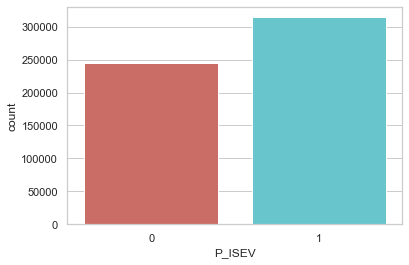

In [23]:
sns.countplot(x='P_ISEV', data=data, palette='hls')
plt.rcParams["figure.figsize"] = [12,5]
plt.show()

In [24]:
data['C_YEAR'].value_counts()

2012    180168
2013    178941
2014    165375
2011     34864
Name: C_YEAR, dtype: int64

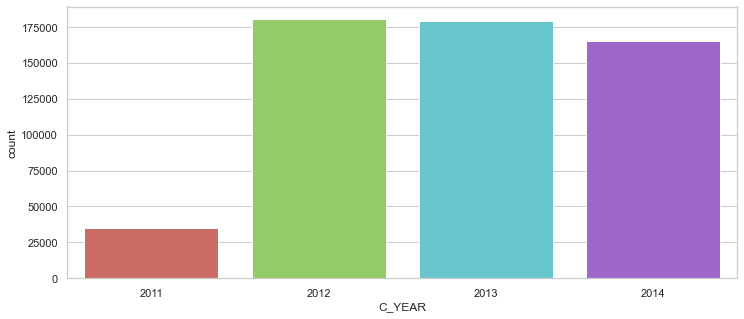

In [25]:
sns.countplot(x='C_YEAR', data=data, palette='hls')
plt.show()

In [26]:
data['C_MNTH'].value_counts()

12    60710
11    60444
10    51061
8     48805
7     48313
9     46792
6     45883
1     45386
5     42674
2     38278
3     36725
4     34277
Name: C_MNTH, dtype: int64

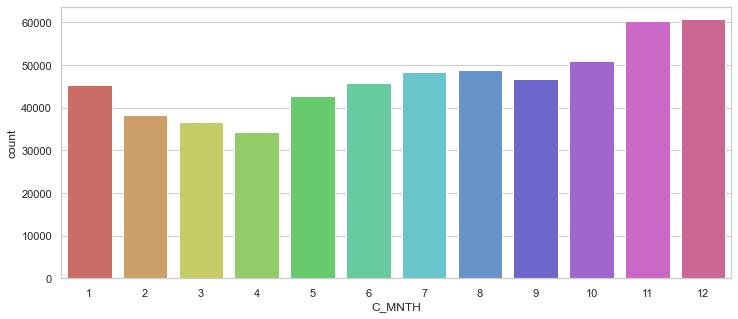

In [27]:
sns.countplot(x='C_MNTH', data=data, palette='hls')
plt.show()

In [28]:
data['C_WDAY'].value_counts()

5    95259
4    85286
6    79738
3    79565
2    79213
1    74237
7    66050
Name: C_WDAY, dtype: int64

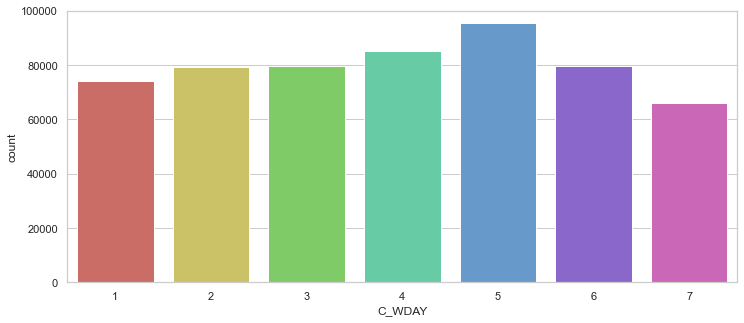

In [29]:
sns.countplot(x='C_WDAY', data=data, palette='hls')
plt.show()

In [30]:
data['C_HOUR'].value_counts()

[15.0, 18.0)    153215
[12.0, 15.0)    110636
[18.0, 21.0)     81906
[9.0, 12.0)      80144
[6.0, 9.0)       64625
[21.0, inf)      40014
[0.0, 3.0)       16528
[3.0, 6.0)       12280
Name: C_HOUR, dtype: int64

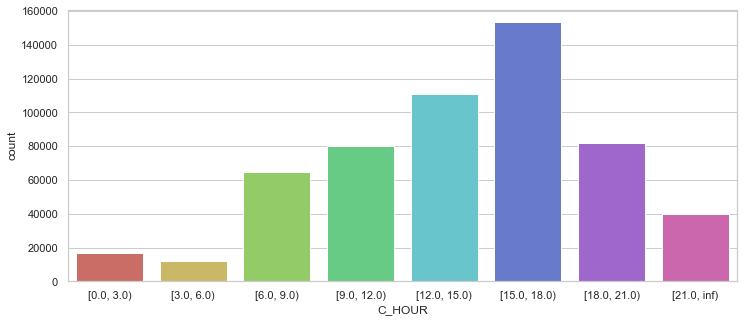

In [31]:
sns.countplot(x='C_HOUR', data=data, palette='hls')
plt.show()

In [32]:
data['C_VEHS'].value_counts()

[1.0, 6.0)     556075
[6.0, 26.0)      3031
[26.0, inf)       242
Name: C_VEHS, dtype: int64

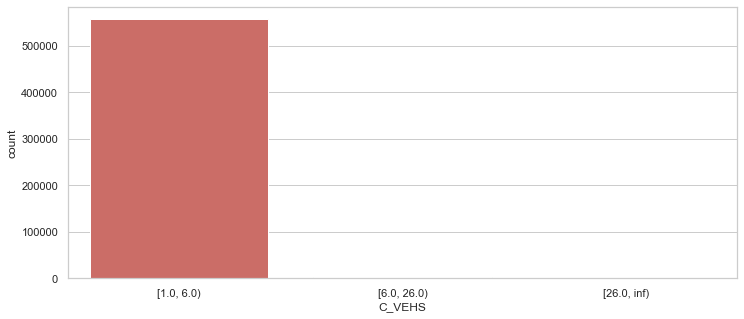

In [33]:
sns.countplot(x='C_VEHS', data=data, palette='hls')
plt.show()

In [34]:
data['C_CONF'].value_counts()

[21.0, 31.0)    234181
[31.0, 41.0)    218489
[1.0, 21.0)     102343
[41.0, inf)       4335
Name: C_CONF, dtype: int64

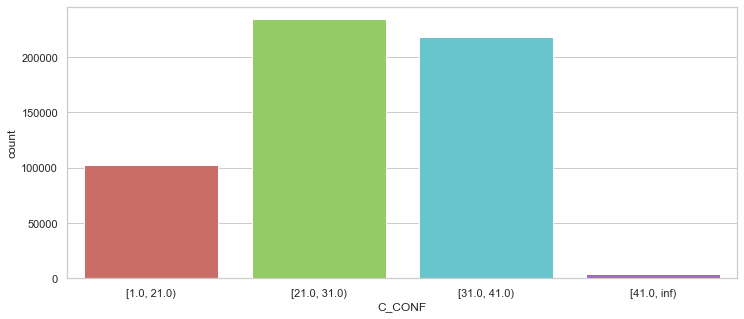

In [35]:
sns.countplot(x='C_CONF', data=data, palette='hls')
plt.show()

In [36]:
data['C_RCFG'].value_counts()

2     290706
1     230455
3      28568
5       5335
4       1527
8       1213
6        855
9        521
10       112
7         56
Name: C_RCFG, dtype: int64

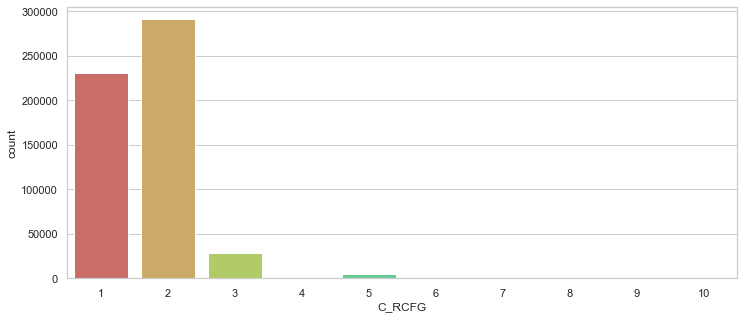

In [37]:
sns.countplot(x='C_RCFG', data=data, palette='hls')
plt.show()

In [38]:
data['C_WTHR'].value_counts()

1    401194
3     58952
2     50777
4     34477
6      9251
5      3007
7      1690
Name: C_WTHR, dtype: int64

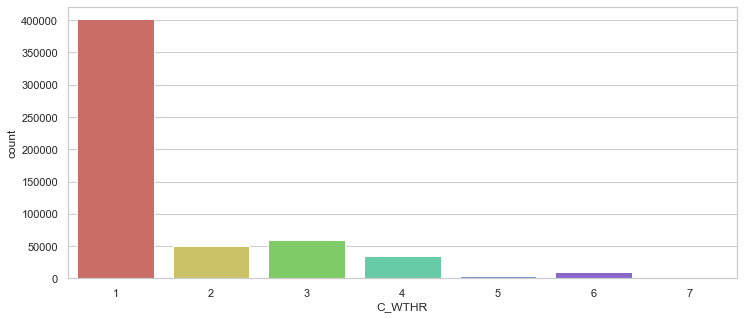

In [39]:
sns.countplot(x='C_WTHR', data=data, palette='hls')
plt.show()

In [40]:
data['C_RSUR'].value_counts()

1    380311
2    107833
5     34748
3     23980
4      9732
6      2196
7       391
8       124
9        33
Name: C_RSUR, dtype: int64

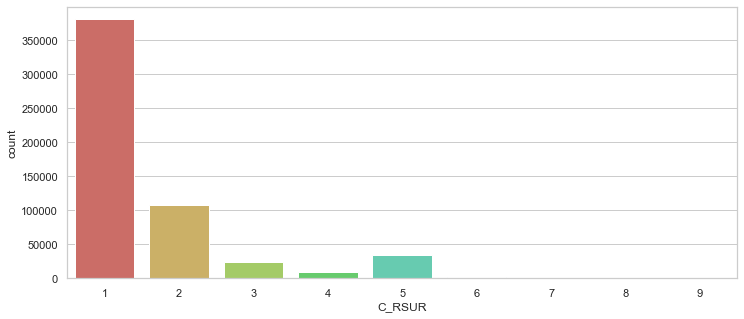

In [41]:
sns.countplot(x='C_RSUR', data=data, palette='hls')
plt.show()

In [42]:
data['C_RALN'].value_counts()

1    442924
2     53847
3     33352
4     18238
5      6189
6      4798
Name: C_RALN, dtype: int64

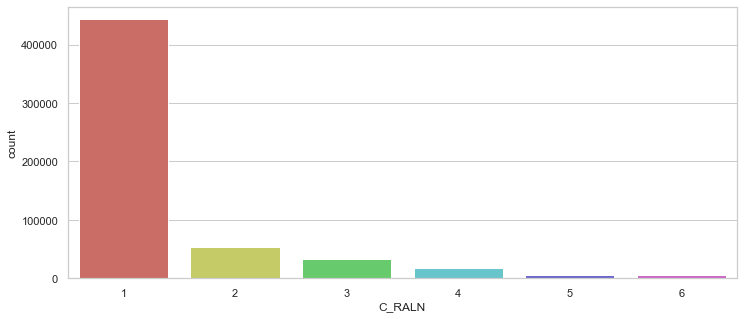

In [43]:
sns.countplot(x='C_RALN', data=data, palette='hls')
plt.show()

In [44]:
data['C_TRAF'].value_counts()

[18.0, inf)     292067
[1.0, 3.0)      184501
[3.0, 6.0)       75027
[8.0, 10.0)       3037
[6.0, 7.0)        2404
[10.0, 13.0)      1078
[13.0, 15.0)       593
[15.0, 17.0)       423
[7.0, 8.0)         151
[17.0, 18.0)        67
Name: C_TRAF, dtype: int64

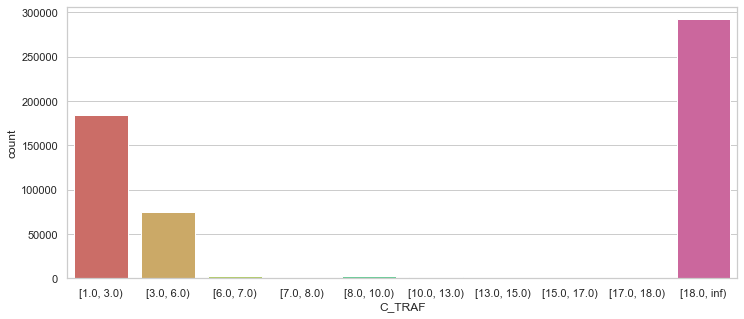

In [45]:
sns.countplot(x='C_TRAF', data=data, palette='hls')
plt.show()

In [46]:
data['V_TYPE'].value_counts()

[0.0, 5.0)      508686
[5.0, 8.0)       24107
[14.0, 18.0)     11505
[9.0, 14.0)       7947
[8.0, 9.0)        6544
[18.0, inf)        559
Name: V_TYPE, dtype: int64

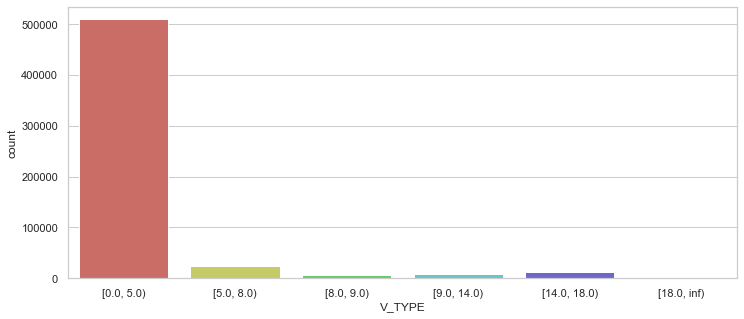

In [47]:
sns.countplot(x='V_TYPE', data=data, palette='hls')
plt.show()

In [48]:
data['V_YEAR'].value_counts()

[2000.0, 2010.0)    351456
[2010.0, inf)       134051
[1990.0, 2000.0)     68597
[1980.0, 1990.0)      4409
[1950.0, 1980.0)       793
[1900.0, 1950.0)        42
Name: V_YEAR, dtype: int64

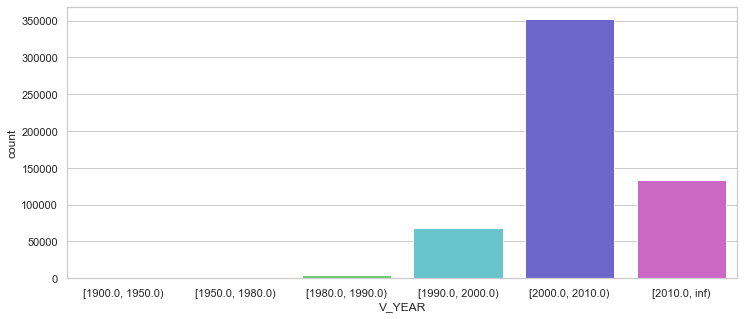

In [49]:
sns.countplot(x='V_YEAR', data=data, palette='hls')
plt.show()

In [50]:
data['P_SEX'].value_counts()

M    294077
F    265271
Name: P_SEX, dtype: int64

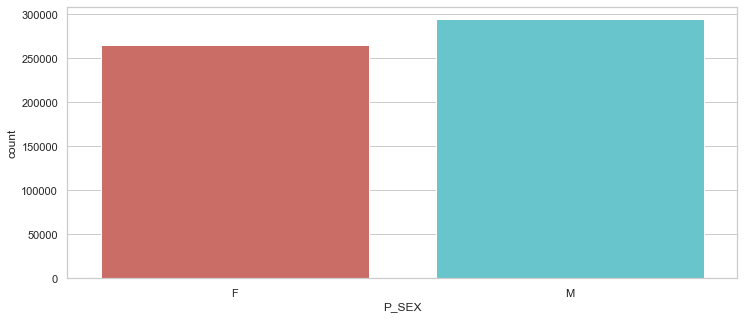

In [51]:
sns.countplot(x='P_SEX', data=data, palette='hls')
plt.show()

In [52]:
data['P_PSN'].value_counts()

[11.0, 21.0)    491971
[21.0, 31.0)     63540
[31.0, 34.0)      3728
[98.0, 99.0)        72
[34.0, 98.0)        37
[99.0, inf)          0
Name: P_PSN, dtype: int64

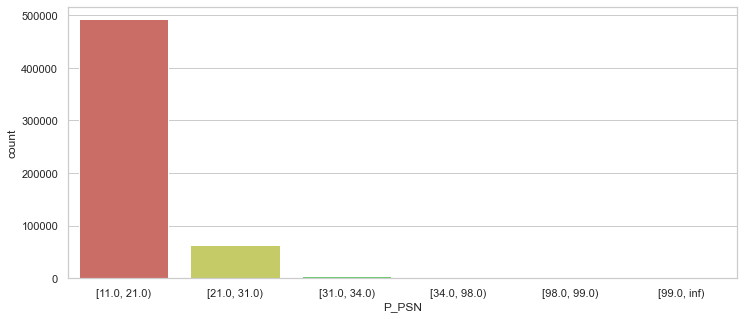

In [53]:
sns.countplot(x='P_PSN', data=data, palette='hls')
plt.show()

In [54]:
data['P_SAFE'].value_counts()

2     527845
9      10416
1      10371
13      6552
12      4162
10         2
11         0
Name: P_SAFE, dtype: int64

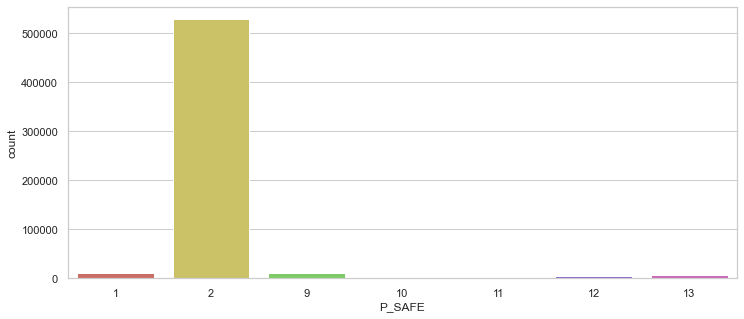

In [55]:
sns.countplot(x='P_SAFE', data=data, palette='hls')
plt.show()

In [56]:
data['P_USER'].value_counts()

1    383086
2    164757
5     10921
4       584
Name: P_USER, dtype: int64

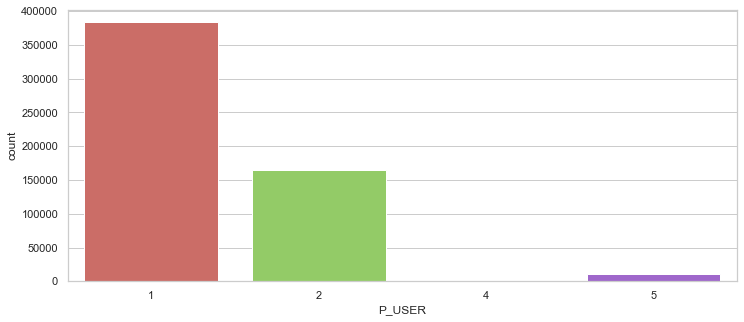

In [57]:
sns.countplot(x='P_USER', data=data, palette='hls')
plt.show()

# Prepare Data for Maching Learning

In [58]:
# Convert data to categorical features (get dummy variables) 
cat_vars=['C_YEAR','C_MNTH','C_WDAY','C_HOUR','C_VEHS','C_CONF','C_RCFG','C_WTHR','C_RSUR','C_RALN','C_TRAF',
         'V_TYPE','V_YEAR','P_SEX','P_AGE','P_PSN','P_SAFE','P_USER']
train = data['P_ISEV']
for var in cat_vars:
    cat_list = pd.get_dummies(data[var], prefix=var, drop_first=True)
    train = pd.concat([train,cat_list],axis=1)

categories = train.drop('P_ISEV',axis=1).columns.values
    
train.columns.values

array(['P_ISEV', 'C_YEAR_2012', 'C_YEAR_2013', 'C_YEAR_2014', 'C_MNTH_2',
       'C_MNTH_3', 'C_MNTH_4', 'C_MNTH_5', 'C_MNTH_6', 'C_MNTH_7',
       'C_MNTH_8', 'C_MNTH_9', 'C_MNTH_10', 'C_MNTH_11', 'C_MNTH_12',
       'C_WDAY_2', 'C_WDAY_3', 'C_WDAY_4', 'C_WDAY_5', 'C_WDAY_6',
       'C_WDAY_7', 'C_HOUR_[3.0, 6.0)', 'C_HOUR_[6.0, 9.0)',
       'C_HOUR_[9.0, 12.0)', 'C_HOUR_[12.0, 15.0)', 'C_HOUR_[15.0, 18.0)',
       'C_HOUR_[18.0, 21.0)', 'C_HOUR_[21.0, inf)', 'C_VEHS_[6.0, 26.0)',
       'C_VEHS_[26.0, inf)', 'C_CONF_[21.0, 31.0)', 'C_CONF_[31.0, 41.0)',
       'C_CONF_[41.0, inf)', 'C_RCFG_2', 'C_RCFG_3', 'C_RCFG_4',
       'C_RCFG_5', 'C_RCFG_6', 'C_RCFG_7', 'C_RCFG_8', 'C_RCFG_9',
       'C_RCFG_10', 'C_WTHR_2', 'C_WTHR_3', 'C_WTHR_4', 'C_WTHR_5',
       'C_WTHR_6', 'C_WTHR_7', 'C_RSUR_2', 'C_RSUR_3', 'C_RSUR_4',
       'C_RSUR_5', 'C_RSUR_6', 'C_RSUR_7', 'C_RSUR_8', 'C_RSUR_9',
       'C_RALN_2', 'C_RALN_3', 'C_RALN_4', 'C_RALN_5', 'C_RALN_6',
       'C_TRAF_[3.0, 6.0)', 'C_TRAF_

In [59]:
# Use K-Fold Cross Validation with K=10
K = 10
kfold = KFold(n_splits=K, shuffle=True, random_state=102)
kfold.get_n_splits(train)
print(kfold)

KFold(n_splits=10, random_state=102, shuffle=True)


In [60]:
# Split our data based on folds
X = np.array(train.drop('P_ISEV',axis=1))
y = np.array(train['P_ISEV'])

# Use lists to store all the datasets needed for each fold
X_train = []
X_test = []
y_train = []
y_test = []

for train_index, test_index in kfold.split(train):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train.append(X[train_index])
    X_test.append(X[test_index])
    y_train.append(y[train_index])
    y_test.append(y[test_index])

TRAIN: [     0      1      2 ... 559344 559346 559347] TEST: [     3     17     19 ... 559338 559339 559345]
TRAIN: [     0      1      2 ... 559345 559346 559347] TEST: [    10     13     22 ... 559301 559324 559325]
TRAIN: [     1      2      3 ... 559345 559346 559347] TEST: [     0      8     12 ... 559314 559319 559322]
TRAIN: [     0      1      2 ... 559345 559346 559347] TEST: [     4      9     11 ... 559302 559328 559334]
TRAIN: [     0      1      2 ... 559345 559346 559347] TEST: [     7     20     29 ... 559283 559317 559318]
TRAIN: [     0      1      2 ... 559345 559346 559347] TEST: [    16     25     27 ... 559312 559327 559336]
TRAIN: [     0      1      2 ... 559344 559345 559347] TEST: [     6     37     49 ... 559335 559340 559346]
TRAIN: [     0      1      3 ... 559345 559346 559347] TEST: [     2      5     21 ... 559306 559337 559342]
TRAIN: [     0      1      2 ... 559345 559346 559347] TEST: [    26     48     64 ... 559326 559331 559344]
TRAIN: [     0     

# Baseline Model (Majority Class Prediction)

In [61]:
# Create a baseline model where you guess the same class for everything

# Want a list of all predictions for each of the 10 folds (predicitons for every row in the data set)
predictions = []
# Keep a list of accuracies for each fold
accuracies = []

# For each fold
for i in range(K):
    
    # Train the model on the training set (get the most frequent class)
    most_frequent = statistics.mode(y_train[i])
    
    # Evaluate the model on the testing set (use the most frequent class from above as predictions for all)
    fold_predictions = [most_frequent] * len(y_test[i])
    accuracies.append(accuracy_score(y_test[i], fold_predictions))
    predictions = predictions + fold_predictions
accuracies

[0.5624743005273979,
 0.5639939215160454,
 0.5590238669884687,
 0.5644766246536158,
 0.5585947975328507,
 0.5617591847680343,
 0.564726915169393,
 0.5584517743809779,
 0.5652376014588623,
 0.5611256123288161]

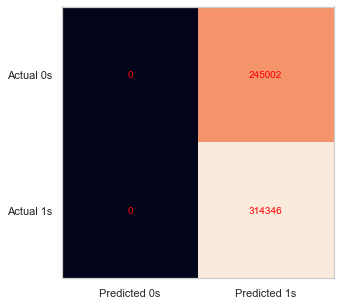

In [62]:
# Create the confusion matrix
cm = confusion_matrix(np.hstack(y_test),predictions)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    245002
           1       0.56      1.00      0.72    314346

    accuracy                           0.56    559348
   macro avg       0.28      0.50      0.36    559348
weighted avg       0.32      0.56      0.40    559348



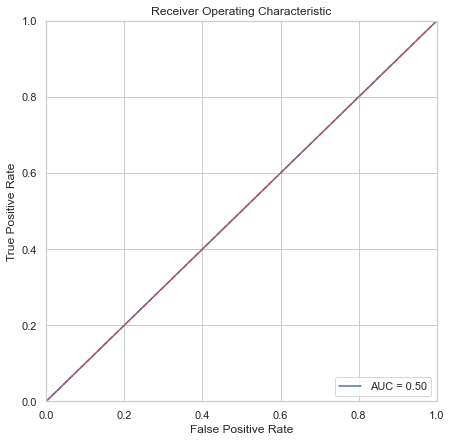

In [63]:
# Evaluate model using the testing data set
print(classification_report(np.hstack(y_test),predictions))

# Create ROC curve and get AUC
fpr, tpr, threshold = roc_curve(np.hstack(y_test), predictions)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(7, 7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Logistic Regression

In [64]:
# Create logistic regression model

# Keep a list of all predictions (1s and 0s) for each of the 10 folds (predicitons for every row in the data set)
predictions = []
# Keep a list of all prediction probabilities for each of the 10 folds 
probability_preds = []
# Keep a list of accuracies for each fold
accuracies = []

# For each fold
for i in range(K):
    logmodel = LogisticRegression()
    logmodel.fit(X_train[i],y_train[i])
    fold_predictions = logmodel.predict(X_test[i])
    fold_probabilities = logmodel.predict_proba(X_test[i])[:,1]
    predictions = predictions + list(fold_predictions)
    probability_preds = probability_preds + list(fold_probabilities)
    accuracies.append(accuracy_score(y_test[i], fold_predictions))
accuracies

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    

[0.6437293286850809,
 0.64717976222401,
 0.6458389201752034,
 0.6470724948601054,
 0.6447304907481899,
 0.6460355770090284,
 0.6458389201752034,
 0.644945025475999,
 0.6476382879822649,
 0.6486752243715808]

In [65]:
# Get model coefficients (for the last fold)
coefficients = logmodel.coef_[0]
cat_coefs = pd.DataFrame({'category': categories, 'coefficient': coefficients})
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(cat_coefs)

                    category  coefficient
0                C_YEAR_2012     0.027116
1                C_YEAR_2013     0.037504
2                C_YEAR_2014     0.060807
3                   C_MNTH_2     0.067474
4                   C_MNTH_3     0.139520
5                   C_MNTH_4     0.125748
6                   C_MNTH_5     0.099178
7                   C_MNTH_6     0.065077
8                   C_MNTH_7     0.057534
9                   C_MNTH_8     0.063628
10                  C_MNTH_9     0.084050
11                 C_MNTH_10     0.078794
12                 C_MNTH_11     0.120449
13                 C_MNTH_12     0.022533
14                  C_WDAY_2    -0.018755
15                  C_WDAY_3    -0.031661
16                  C_WDAY_4    -0.058132
17                  C_WDAY_5    -0.059578
18                  C_WDAY_6    -0.111248
19                  C_WDAY_7    -0.093291
20         C_HOUR_[3.0, 6.0)     0.201475
21         C_HOUR_[6.0, 9.0)    -0.332873
22        C_HOUR_[9.0, 12.0)    -0

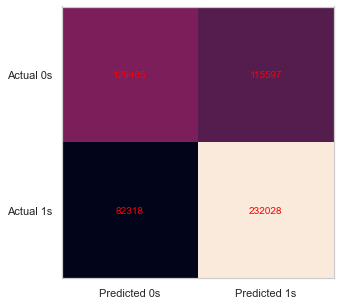

In [66]:
# Create the confusion matrix
cm = confusion_matrix(np.hstack(y_test),predictions)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

              precision    recall  f1-score   support

           0       0.61      0.53      0.57    245002
           1       0.67      0.74      0.70    314346

    accuracy                           0.65    559348
   macro avg       0.64      0.63      0.63    559348
weighted avg       0.64      0.65      0.64    559348



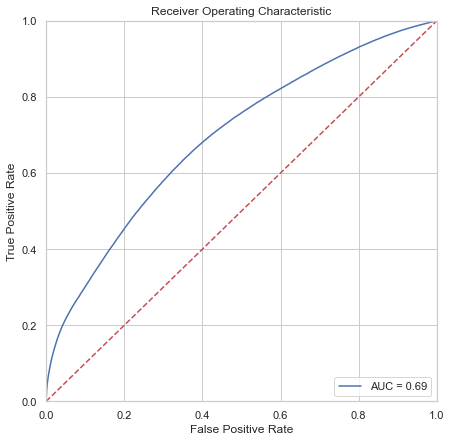

In [67]:
# Evaluate model using the testing data set
print(classification_report(np.hstack(y_test),predictions))

# Create ROC curve and get AUC
fpr, tpr, threshold = roc_curve(np.hstack(y_test), probability_preds)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(7, 7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Neural Network

In [68]:
# Keep a list of all predictions (1s and 0s) for each of the 10 folds (predicitons for every row in the data set)
predictions = []
# Keep a list of all prediction probabilities for each of the 10 folds 
probability_preds = []
# Keep a list of accuracies for each fold
accuracies = []

# For each fold
for i in range(K):
    
    # Split training set into training and validation
    X_train_nn, X_val, y_train_nn, y_val = train_test_split(X_train[i], 
                                                        y_train[i], test_size=0.10, 
                                                        random_state=201)

    # Create the neural network
    model_nn = models.Sequential()
    model_nn.add(layers.Dense(len(categories), input_dim=len(categories), activation='relu'))
    model_nn.add(layers.Dense(20, activation='relu'))
    model_nn.add(layers.Dense(1, activation='sigmoid'))
    model_nn.summary()

    es = EarlyStopping(monitor='accuracy')
    cc = ModelCheckpoint('model.h5', monitor='accuracy', verbose=1, save_best_only=True, mode='min')

    model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model_nn.fit(X_train_nn, y_train_nn, epochs=15, 
                          validation_data=(X_val, y_val),
                          callbacks=[es, cc])

    # Halve the learning rate and run again
    model_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    history = model_nn.fit(X_train_nn, y_train_nn, epochs=15, 
                          validation_data=(X_val, y_val),
                          callbacks=[es, cc])

    # Halve the learning rate again and run again
    model_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00025),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    history = model_nn.fit(X_train_nn, y_train_nn, epochs=15, 
                          validation_data=(X_val, y_val),
                          callbacks=[es, cc])

    # Get prediction probabilities
    fold_probabilities = model_nn.predict(X_test[i])

    # Get predictions in 1s and 0s
    fold_predictions = np.array(fold_probabilities, copy=True) 
    fold_predictions[fold_predictions >= 0.5] = 1
    fold_predictions[fold_predictions < 0.5] = 0
    
    predictions = predictions + list(fold_predictions)
    probability_preds = probability_preds + list(fold_probabilities)
    accuracies.append(accuracy_score(y_test[i], fold_predictions))
    
print(accuracies)  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 103)               10712     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 12,813
Trainable params: 12,813
Non-trainable params: 0
_________________________________________________________________
Train on 453071 samples, validate on 50342 samples
Epoch 1/15
452352/453071 [============================>.] - ETA: 0s - loss: 0.6134 - accuracy: 0.6535
Epoch 00001: accuracy improved from inf to 0.65355, saving model to model.h5
453071/453071 [==============================] - 32s 72us/sample - loss: 0.6134 - accuracy: 0.6536 - val_loss: 0.6066 - val_accuracy: 0.6611
Epoch 2/15


452736/453071 [============================>.] - ETA: 0s - loss: 0.6137 - accuracy: 0.6534
Epoch 00001: accuracy improved from inf to 0.65334, saving model to model.h5
453071/453071 [==============================] - 28s 62us/sample - loss: 0.6137 - accuracy: 0.6533 - val_loss: 0.6068 - val_accuracy: 0.6605
Epoch 2/15
452672/453071 [============================>.] - ETA: 0s - loss: 0.6042 - accuracy: 0.6623
Epoch 00002: accuracy did not improve from 0.65334
453071/453071 [==============================] - 28s 61us/sample - loss: 0.6042 - accuracy: 0.6622 - val_loss: 0.6073 - val_accuracy: 0.6589
Epoch 3/15
452608/453071 [============================>.] - ETA: 0s - loss: 0.6018 - accuracy: 0.6638
Epoch 00003: accuracy did not improve from 0.65334
453071/453071 [==============================] - 27s 60us/sample - loss: 0.6018 - accuracy: 0.6638 - val_loss: 0.6048 - val_accuracy: 0.6609
Epoch 4/15
452864/453071 [============================>.] - ETA: 0s - loss: 0.6000 - accuracy: 0.6653
E

452736/453071 [============================>.] - ETA: 0s - loss: 0.6130 - accuracy: 0.6544 ETA: 1s - l
Epoch 00001: accuracy improved from inf to 0.65439, saving model to model.h5
453071/453071 [==============================] - 28s 61us/sample - loss: 0.6130 - accuracy: 0.6544 - val_loss: 0.6072 - val_accuracy: 0.6615
Epoch 2/15
452640/453071 [============================>.] - ETA: 0s - loss: 0.6044 - accuracy: 0.6619 ETA - E - ETA: 1s - los - ETA: 0s - loss: 0.6
Epoch 00002: accuracy did not improve from 0.65439
453071/453071 [==============================] - 27s 60us/sample - loss: 0.6044 - accuracy: 0.6619 - val_loss: 0.6049 - val_accuracy: 0.6623
Epoch 3/15
452832/453071 [============================>.] - ETA: 0s - loss: 0.6019 - accuracy: 0.6636 ETA: 0s - loss: 0.6019 - accuracy: 0.
Epoch 00003: accuracy did not improve from 0.65439
453071/453071 [==============================] - 27s 60us/sample - loss: 0.6019 - accuracy: 0.6636 - val_loss: 0.6031 - val_accuracy: 0.6637
Epoch 4

452928/453071 [============================>.] - ETA: 0s - loss: 0.6002 - accuracy: 0.6650
Epoch 00004: accuracy did not improve from 0.65348
453071/453071 [==============================] - 24s 52us/sample - loss: 0.6002 - accuracy: 0.6650 - val_loss: 0.6029 - val_accuracy: 0.6640
Epoch 5/15
452608/453071 [============================>.] - ETA: 0s - loss: 0.5987 - accuracy: 0.6662
Epoch 00005: accuracy did not improve from 0.65348
453071/453071 [==============================] - 24s 52us/sample - loss: 0.5986 - accuracy: 0.6663 - val_loss: 0.6021 - val_accuracy: 0.6643
Epoch 6/15
453024/453071 [============================>.] - ETA: 0s - loss: 0.5974 - accuracy: 0.6674
Epoch 00006: accuracy did not improve from 0.65348
453071/453071 [==============================] - 24s 53us/sample - loss: 0.5974 - accuracy: 0.6674 - val_loss: 0.6025 - val_accuracy: 0.6623
Epoch 7/15
452704/453071 [============================>.] - ETA: 0s - loss: 0.5960 - accuracy: 0.6681
Epoch 00007: accuracy did n

Epoch 4/15
452480/453071 [============================>.] - ETA: 0s - loss: 0.5779 - accuracy: 0.6809
Epoch 00004: accuracy did not improve from 0.65348
453071/453071 [==============================] - 26s 56us/sample - loss: 0.5779 - accuracy: 0.6809 - val_loss: 0.6161 - val_accuracy: 0.6615
Epoch 5/15
452928/453071 [============================>.] - ETA: 0s - loss: 0.5777 - accuracy: 0.6810
Epoch 00005: accuracy did not improve from 0.65348
453071/453071 [==============================] - 25s 56us/sample - loss: 0.5777 - accuracy: 0.6810 - val_loss: 0.6162 - val_accuracy: 0.6614
Epoch 6/15
453056/453071 [============================>.] - ETA: 0s - loss: 0.5775 - accuracy: 0.6812
Epoch 00006: accuracy did not improve from 0.65348
453071/453071 [==============================] - 25s 54us/sample - loss: 0.5775 - accuracy: 0.6812 - val_loss: 0.6164 - val_accuracy: 0.6608
Epoch 7/15
452672/453071 [============================>.] - ETA: 0s - loss: 0.5774 - accuracy: 0.6813
Epoch 00007: acc

Epoch 8/15
452384/453071 [============================>.] - ETA: 0s - loss: 0.5836 - accuracy: 0.6774
Epoch 00008: accuracy did not improve from 0.65518
453071/453071 [==============================] - 24s 53us/sample - loss: 0.5836 - accuracy: 0.6774 - val_loss: 0.6113 - val_accuracy: 0.6571
Epoch 9/15
452160/453071 [============================>.] - ETA: 0s - loss: 0.5832 - accuracy: 0.6778
Epoch 00009: accuracy did not improve from 0.65518
453071/453071 [==============================] - 24s 53us/sample - loss: 0.5833 - accuracy: 0.6777 - val_loss: 0.6120 - val_accuracy: 0.6580
Epoch 10/15
452320/453071 [============================>.] - ETA: 0s - loss: 0.5830 - accuracy: 0.6778
Epoch 00010: accuracy did not improve from 0.65518
453071/453071 [==============================] - 24s 54us/sample - loss: 0.5830 - accuracy: 0.6778 - val_loss: 0.6145 - val_accuracy: 0.6575
Epoch 11/15
452736/453071 [============================>.] - ETA: 0s - loss: 0.5826 - accuracy: 0.6783
Epoch 00011: a

Epoch 14/15
452320/453071 [============================>.] - ETA: 0s - loss: 0.5904 - accuracy: 0.6719
Epoch 00014: accuracy did not improve from 0.65435
453071/453071 [==============================] - 24s 54us/sample - loss: 0.5904 - accuracy: 0.6719 - val_loss: 0.6079 - val_accuracy: 0.6615
Epoch 15/15
452544/453071 [============================>.] - ETA: 0s - loss: 0.5899 - accuracy: 0.6726
Epoch 00015: accuracy did not improve from 0.65435
453071/453071 [==============================] - 33s 72us/sample - loss: 0.5899 - accuracy: 0.6726 - val_loss: 0.6103 - val_accuracy: 0.6606
Train on 453071 samples, validate on 50342 samples
Epoch 1/15
453056/453071 [============================>.] - ETA: 0s - loss: 0.5864 - accuracy: 0.6746
Epoch 00001: accuracy did not improve from 0.65435
453071/453071 [==============================] - 27s 60us/sample - loss: 0.5864 - accuracy: 0.6746 - val_loss: 0.6088 - val_accuracy: 0.6619
Epoch 2/15
452768/453071 [============================>.] - ETA: 

452704/453071 [============================>.] - ETA: 0s - loss: 0.5900 - accuracy: 0.6727
Epoch 00014: accuracy did not improve from 0.65371
453071/453071 [==============================] - 27s 60us/sample - loss: 0.5900 - accuracy: 0.6726 - val_loss: 0.6052 - val_accuracy: 0.6621
Epoch 15/15
452800/453071 [============================>.] - ETA: 0s - loss: 0.5893 - accuracy: 0.6732
Epoch 00015: accuracy did not improve from 0.65371
453071/453071 [==============================] - 27s 60us/sample - loss: 0.5893 - accuracy: 0.6732 - val_loss: 0.6047 - val_accuracy: 0.6616
Train on 453071 samples, validate on 50342 samples
Epoch 1/15
452704/453071 [============================>.] - ETA: 0s - loss: 0.5858 - accuracy: 0.6754
Epoch 00001: accuracy did not improve from 0.65371
453071/453071 [==============================] - 27s 60us/sample - loss: 0.5858 - accuracy: 0.6753 - val_loss: 0.6073 - val_accuracy: 0.6625
Epoch 2/15
452960/453071 [============================>.] - ETA: 0s - loss: 0

452800/453071 [============================>.] - ETA: 0s - loss: 0.5913 - accuracy: 0.6719
Epoch 00012: accuracy did not improve from 0.65475
453071/453071 [==============================] - 27s 60us/sample - loss: 0.5913 - accuracy: 0.6719 - val_loss: 0.6059 - val_accuracy: 0.6623
Epoch 13/15
452736/453071 [============================>.] - ETA: 0s - loss: 0.5906 - accuracy: 0.6725
Epoch 00013: accuracy did not improve from 0.65475
453071/453071 [==============================] - 27s 60us/sample - loss: 0.5906 - accuracy: 0.6725 - val_loss: 0.6047 - val_accuracy: 0.6620
Epoch 14/15
452768/453071 [============================>.] - ETA: 0s - loss: 0.5899 - accuracy: 0.6724
Epoch 00014: accuracy did not improve from 0.65475
453071/453071 [==============================] - 27s 60us/sample - loss: 0.5899 - accuracy: 0.6724 - val_loss: 0.6051 - val_accuracy: 0.6628
Train on 453071 samples, validate on 50342 samples
Epoch 1/15
452704/453071 [============================>.] - ETA: 0s - loss: 

Epoch 3/15
452992/453072 [============================>.] - ETA: 0s - loss: 0.5876 - accuracy: 0.6744
Epoch 00003: accuracy did not improve from 0.65474
453072/453072 [==============================] - 29s 65us/sample - loss: 0.5876 - accuracy: 0.6744 - val_loss: 0.6070 - val_accuracy: 0.6623
Epoch 4/15
452480/453072 [============================>.] - ETA: 0s - loss: 0.5870 - accuracy: 0.6747
Epoch 00004: accuracy did not improve from 0.65474
453072/453072 [==============================] - 29s 65us/sample - loss: 0.5870 - accuracy: 0.6747 - val_loss: 0.6065 - val_accuracy: 0.6622
Epoch 5/15
453056/453072 [============================>.] - ETA: 0s - loss: 0.5865 - accuracy: 0.6749
Epoch 00005: accuracy did not improve from 0.65474
453072/453072 [==============================] - 32s 70us/sample - loss: 0.5865 - accuracy: 0.6749 - val_loss: 0.6073 - val_accuracy: 0.6620
Epoch 6/15
452928/453072 [============================>.] - ETA: 0s - loss: 0.5860 - accuracy: 0.6754
Epoch 00006: acc

452736/453072 [============================>.] - ETA: 0s - loss: 0.5874 - accuracy: 0.6743
Epoch 00001: accuracy did not improve from 0.65285
453072/453072 [==============================] - 30s 66us/sample - loss: 0.5874 - accuracy: 0.6742 - val_loss: 0.6039 - val_accuracy: 0.6630
Epoch 2/15
452800/453072 [============================>.] - ETA: 0s - loss: 0.5863 - accuracy: 0.6754
Epoch 00002: accuracy did not improve from 0.65285
453072/453072 [==============================] - 28s 62us/sample - loss: 0.5863 - accuracy: 0.6754 - val_loss: 0.6063 - val_accuracy: 0.6627
Epoch 3/15
452832/453072 [============================>.] - ETA: 0s - loss: 0.5857 - accuracy: 0.6754
Epoch 00003: accuracy did not improve from 0.65285
453072/453072 [==============================] - 27s 59us/sample - loss: 0.5857 - accuracy: 0.6754 - val_loss: 0.6056 - val_accuracy: 0.6624
Epoch 4/15
452320/453072 [============================>.] - ETA: 0s - loss: 0.5853 - accuracy: 0.6756
Epoch 00004: accuracy did n

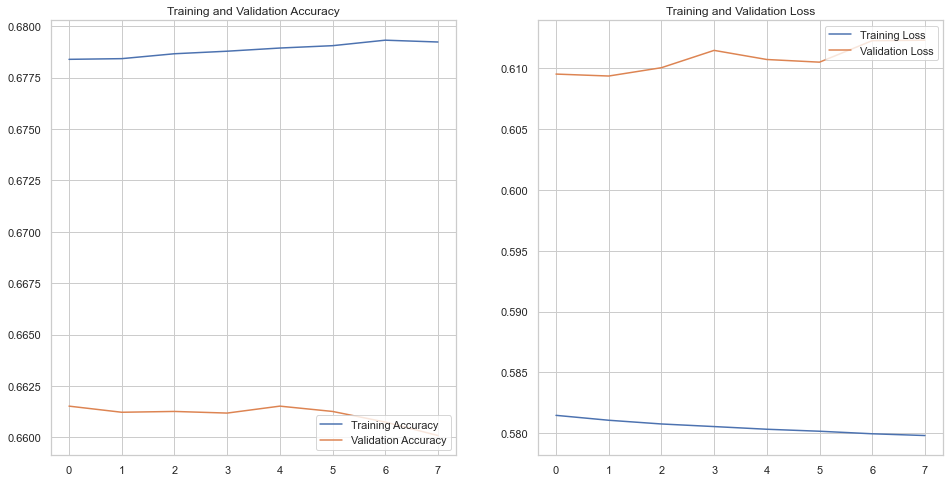

In [69]:
# Plot accuracy and loss (for the last fold)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

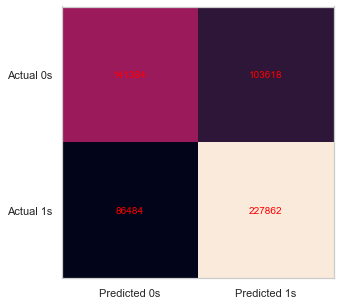

In [70]:
# Create the confusion matrix
cm = confusion_matrix(np.hstack(y_test),predictions)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

              precision    recall  f1-score   support

           0       0.62      0.58      0.60    245002
           1       0.69      0.72      0.71    314346

    accuracy                           0.66    559348
   macro avg       0.65      0.65      0.65    559348
weighted avg       0.66      0.66      0.66    559348



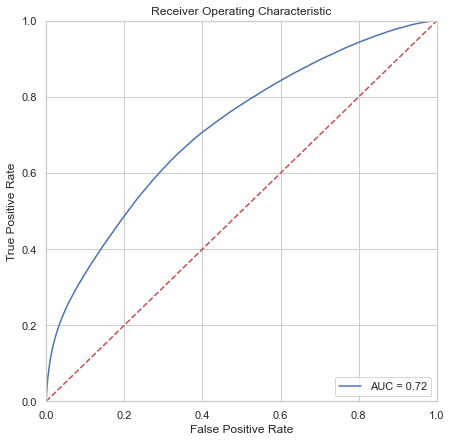

In [71]:
# Evaluate model using the testing data set
print(classification_report(np.hstack(y_test), predictions))

# Create ROC curve and get AUC
fpr, tpr, threshold = roc_curve(np.hstack(y_test), probability_preds)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(7, 7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Decision Tree

In [72]:
# Build the decision tree
# We want to limit the depth to avoid overfitting, so we need to find optimal max_depth
# Train our model using a subset of the training data (like in nerual network above) and use part of it for validation
# Use validation set to find optimal paramaters (i.e. max_depth) and then evaluate model with the testing set

# Keep a list of all predictions (1s and 0s) for each of the 10 folds (predicitons for every row in the data set)
predictions = []
# Keep a list of all prediction probabilities for each of the 10 folds 
probability_preds = []
# Keep a list of accuracies for each fold
accuracies = []

# For each fold
for i in range(K):
    
    # Split training set into training and validation
    X_train_dt, X_val, y_train_dt, y_val = train_test_split(X_train[i], y_train[i], test_size=0.10, random_state=201)

    # Find the best max_depth based on the validation set
    depth_accuracies = []
    for j in range(1,21):
        dt = DecisionTreeClassifier(max_depth=j, random_state=301)
        dt.fit(X_train_dt, y_train_dt)
        depth_predictions = dt.predict(X_val)
        acc = accuracy_score(y_val, depth_predictions)
        depth_accuracies.append(acc)
    optimal_depth = np.argmax(depth_accuracies)
    print(max(depth_accuracies))
    print(optimal_depth)
    
    # Now use optimal max_depth to create final model
    dt = DecisionTreeClassifier(max_depth=optimal_depth)
    dt.fit(X_train_dt, y_train_dt)

    # Get predictions for test set
    fold_predictions = dt.predict(X_test[i])
    fold_probabilities = dt.predict_proba(X_test[i])[:,1]
    predictions = predictions + list(fold_predictions)
    probability_preds = probability_preds + list(fold_probabilities)
    accuracies.append(accuracy_score(y_test[i], fold_predictions))
accuracies

0.6580787414087641
11
0.6568670295180962
11
0.6582177903142505
11
0.6580390131500536
11
0.6561717849906639
12
0.6553772198164555
12
0.656469746930992
12
0.657125263199714
13
0.6578006435977911
10
0.656847165388741
11


[0.6549387682131045,
 0.6571377491731474,
 0.6554572271386431,
 0.6562259765799588,
 0.6560114418521498,
 0.6579780101903996,
 0.6577634754625905,
 0.6552963260927863,
 0.6545929130761254,
 0.6579003825937713]

[Text(502.20000000000005, 489.24, 'P_SEX_M <= 0.5\ngini = 0.492\nsamples = 453072\nvalue = [198441, 254631]\nclass = 1'),
 Text(251.10000000000002, 380.52000000000004, 'P_PSN_[21.0, 31.0) <= 0.5\ngini = 0.459\nsamples = 214983\nvalue = [76699, 138284]\nclass = 1'),
 Text(125.55000000000001, 271.8, 'C_RSUR_5 <= 0.5\ngini = 0.443\nsamples = 187156\nvalue = [62095, 125061]\nclass = 1'),
 Text(62.775000000000006, 163.08000000000004, 'C_RCFG_2 <= 0.5\ngini = 0.451\nsamples = 174519\nvalue = [59859, 114660]\nclass = 1'),
 Text(31.387500000000003, 54.360000000000014, '\n  (...)  \n'),
 Text(94.16250000000001, 54.360000000000014, '\n  (...)  \n'),
 Text(188.32500000000002, 163.08000000000004, 'C_CONF_[21.0, 31.0) <= 0.5\ngini = 0.291\nsamples = 12637\nvalue = [2236, 10401]\nclass = 1'),
 Text(156.9375, 54.360000000000014, '\n  (...)  \n'),
 Text(219.71250000000003, 54.360000000000014, '\n  (...)  \n'),
 Text(376.65000000000003, 271.8, 'P_SAFE_2 <= 0.5\ngini = 0.499\nsamples = 27827\nvalue = [1

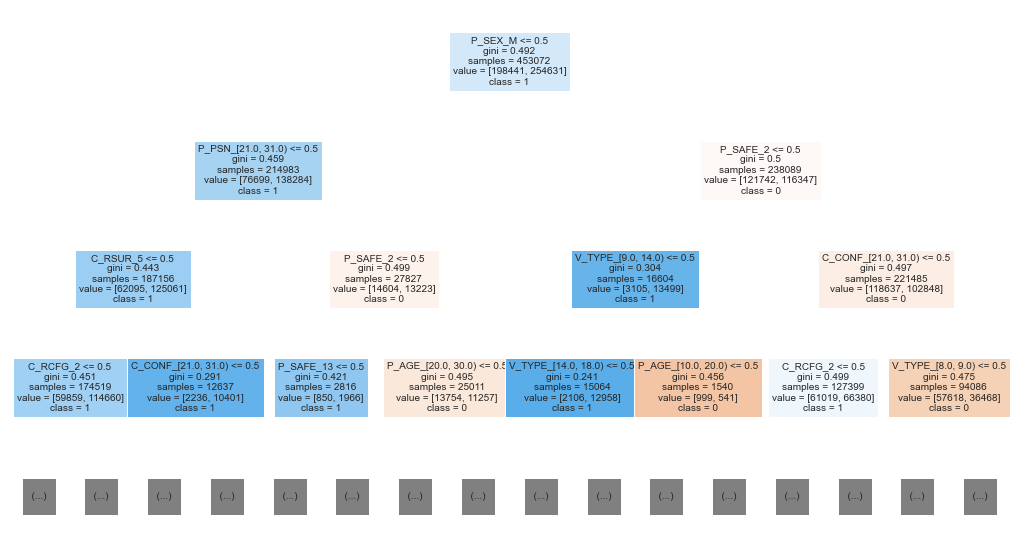

In [73]:
# Visualize the top of the decision tree (for the last fold)
fig, ax = plt.subplots(figsize=(18, 10))
tree.plot_tree(dt,
               feature_names = categories, 
               class_names=['0', '1'],
               max_depth = 3, 
               fontsize=10, 
               filled = True)

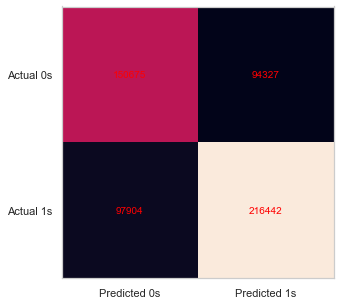

In [74]:
# Create the confusion matrix
cm = confusion_matrix(np.hstack(y_test),predictions)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

              precision    recall  f1-score   support

           0       0.61      0.61      0.61    245002
           1       0.70      0.69      0.69    314346

    accuracy                           0.66    559348
   macro avg       0.65      0.65      0.65    559348
weighted avg       0.66      0.66      0.66    559348



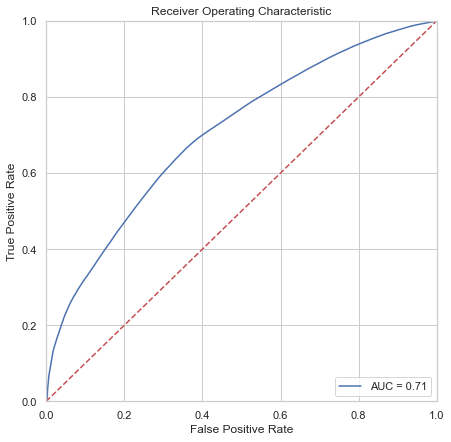

In [75]:
# Evaluate model using the testing data set
print(classification_report(np.hstack(y_test),predictions))

# Create ROC curve and get AUC
fpr, tpr, threshold = roc_curve(np.hstack(y_test), probability_preds)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(7, 7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Naive Bayes

In [76]:
# Keep a list of all predictions (1s and 0s) for each of the 10 folds (predicitons for every row in the data set)
predictions = []
# Keep a list of all prediction probabilities for each of the 10 folds 
probability_preds = []
# Keep a list of accuracies for each fold
accuracies = []

# For each fold
for i in range(K):
    nb = naive_bayes.CategoricalNB()
    model_nb = nb.fit(X_train[i], y_train[i])
    fold_predictions = model_nb.predict(X_test[i])
    fold_probabilities = model_nb.predict_proba(X_test[i])[:,1]
    predictions = predictions + list(fold_predictions)
    probability_preds = probability_preds + list(fold_probabilities)
    accuracies.append(accuracy_score(y_test[i], fold_predictions))
accuracies

[0.627013497809958,
 0.6266559399302762,
 0.6245642263341379,
 0.6235094305890766,
 0.6231161169214267,
 0.6255475105032627,
 0.6235630642710289,
 0.6267632072941808,
 0.62779347087639,
 0.6294025101011906]

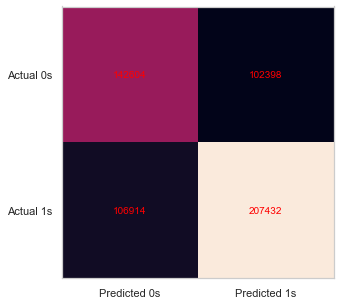

In [77]:
# Create the confusion matrix
cm = confusion_matrix(np.hstack(y_test),predictions)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

              precision    recall  f1-score   support

           0       0.57      0.58      0.58    245002
           1       0.67      0.66      0.66    314346

    accuracy                           0.63    559348
   macro avg       0.62      0.62      0.62    559348
weighted avg       0.63      0.63      0.63    559348



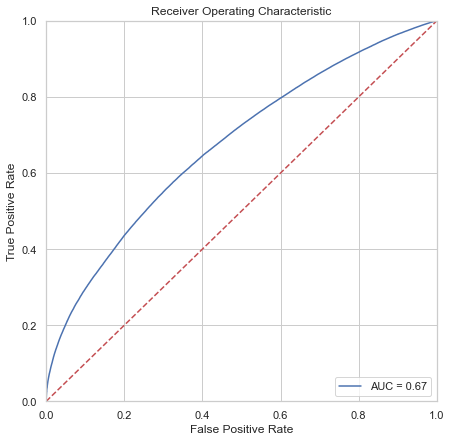

In [78]:
# Evaluate model using the testing data set
print(classification_report(np.hstack(y_test),predictions))

# Create ROC curve and get AUC
fpr, tpr, threshold = roc_curve(np.hstack(y_test), probability_preds)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(7, 7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()